In [1]:
import numpy as np
import pandas as pd
import os
from modules.DS_models_stat import cut_cat
from modules.DS_Planck_Unet import val_pix, west_val, east_val, east
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [5]:
cats = {
    'SZcat(AL)' : pd.read_csv('./Data/detected_cats/SZcatAL.csv'),
    'SZcat(y-map)' : pd.read_csv('./Data/detected_cats/SZcat_ymap.csv'),
    'SZcat(gen)' : pd.read_csv('./Data/detected_cats/SZcatgen.csv')
}
true_cats = {
    'eROSITA' : pd.read_csv('./Data/original_cats/eROSITA.csv')
}

In [6]:
def match_prm(det_cat, true_cat, match_dist=5/60, prms=[]):
    det_sc = SkyCoord(ra=np.array(det_cat['RA'])*u.degree, dec=np.array(det_cat['DEC'])*u.degree, frame='icrs')
    true_sc = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
    
    idx, d2d, _ = det_sc.match_to_catalog_sky(true_sc)
    matched = d2d.degree < match_dist
    det_cat['found'] = False
    det_cat.loc[matched, 'found'] = True
    det_cat['tRA'] = np.nan
    det_cat['tDEC'] = np.nan
    true_cat = true_cat.rename(columns={'RA' : 'tRA', 'DEC' : 'tDEC'})
    
    for prm in prms + ['tRA', 'tDEC']:
        det_cat[prm] = 0
        det_cat[prm].iloc[matched] = np.array(true_cat[prm].iloc[idx[matched]])
    return det_cat

In [7]:
for cat_name in cats:
    df = cats[cat_name]
    df = match_prm(df, true_cats['eROSITA'], match_dist=400/3600, prms=['flux'])
    df = df[df['found']]
    df.index = np.arange(len(df))
    cats[cat_name] = df

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
def flux2prm(ax, df, prm, c='c', alpha=1.0, text='', xlabel=''):
    qf = np.array(df['flux'].quantile(np.arange(0, 1.05, 0.05)))
    qprm = []
    for st, en in zip(qf[:-1], qf[1:]):
        df_cur = df[np.logical_and(st <= df['flux'], df['flux'] <= en)]
        qprm.append(df_cur[prm].mean())
    
    s = ax.scatter(df['flux'], df[prm], alpha=alpha)
    s.set_label(text)
    #ax.plot((qf[:-1] + qf[1:])/2, qprm, c='r')
    
    
    ax.set_ylabel(xlabel)
    
    ax.set_xlabel('flux')
    ax.set_xscale('log')
    ax.set_yticks(np.arange(0, 1.1, 0.1), minor=False)
    ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
    ax.grid(which='minor', axis='both', linestyle=':', alpha=0.5)
    ax.grid(which='major', axis='both', linestyle='--') 

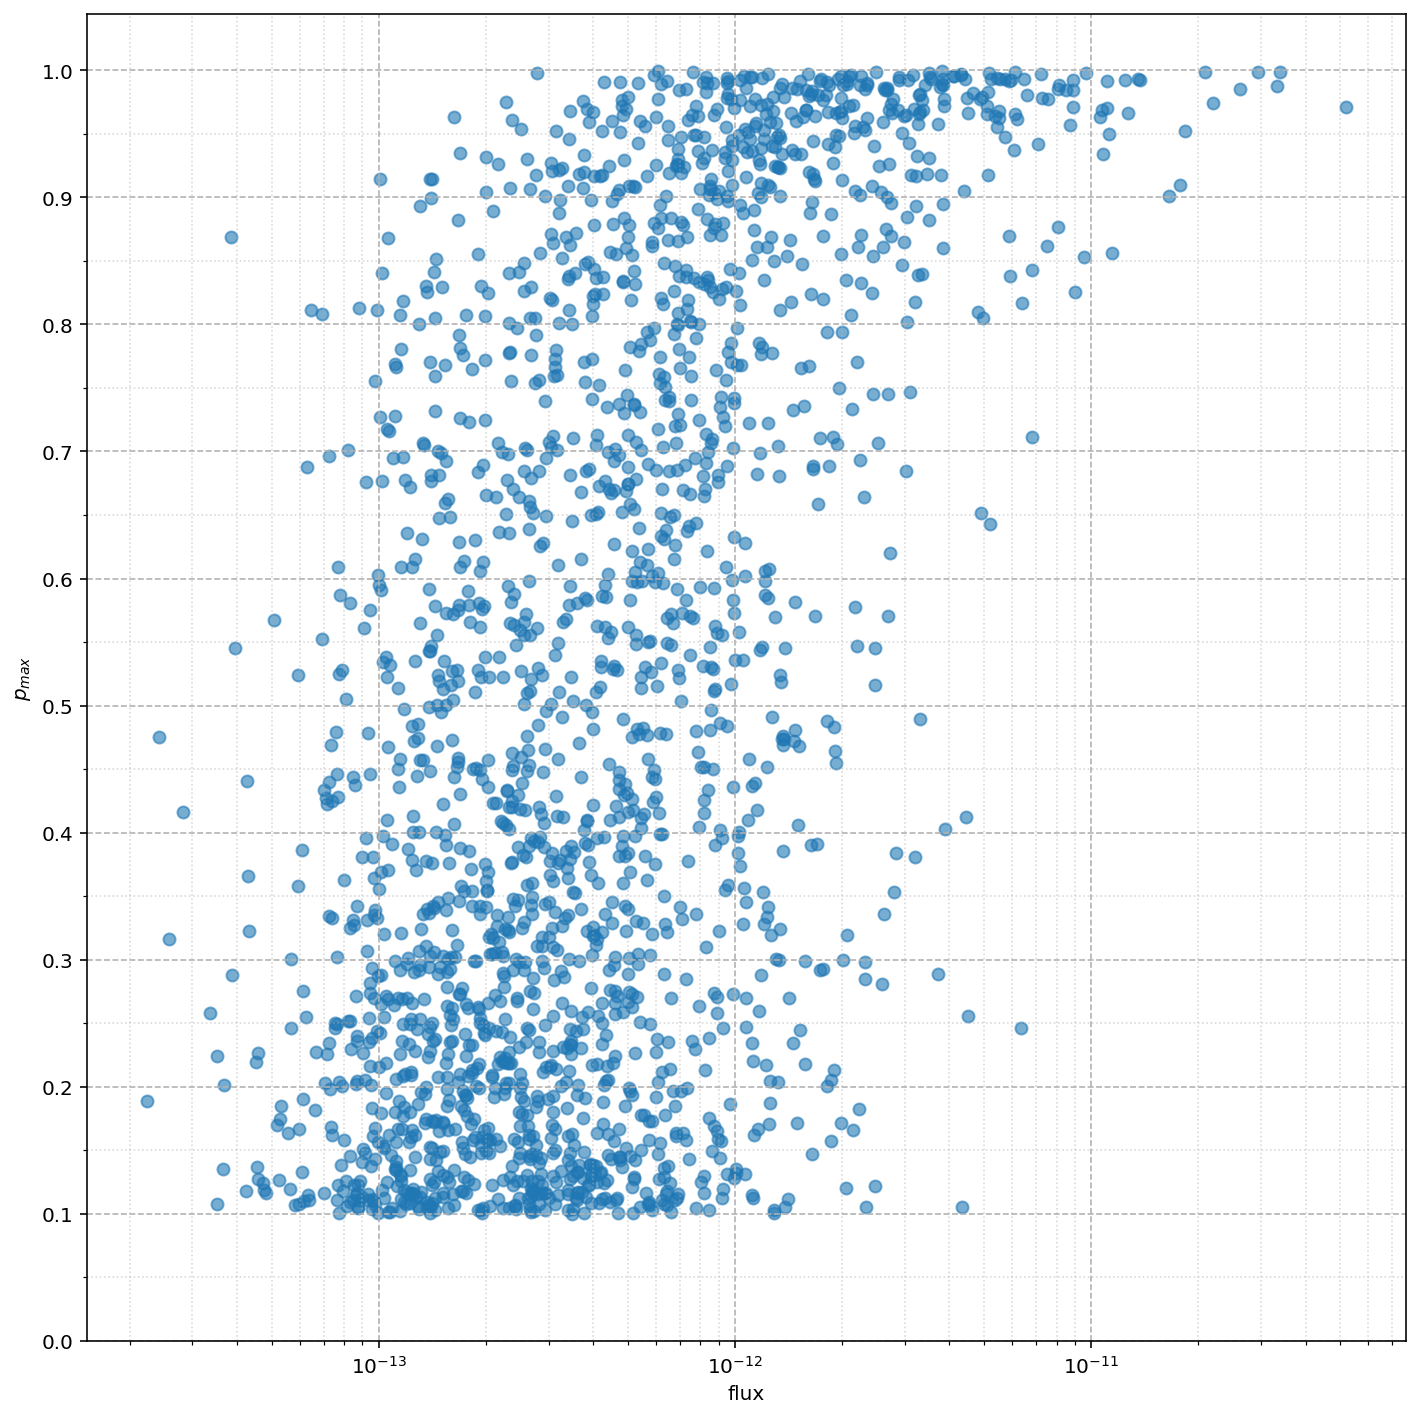

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharey=True)
name = 'SZcat(AL)'
flux2prm(ax, cats[name], 'max_pred', text=name, xlabel='$p_{max}$', alpha=0.6)
fig.tight_layout()